In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet

def preprocess_data(file_path, date_col, target_col, floor_value=None, cap_value=None):
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv(file_path, header=1)
    
    # Rename the 'Time' column to 'ds' and convert its format
    df['ds'] = pd.to_datetime(df[date_col], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
    
    # Rename the target column to 'y'
    df.rename(columns={target_col: 'y'}, inplace=True)
    
    # Drop unneeded columns from the dataframe
    df.drop(columns=[col for col in df.columns if col not in ['ds', 'y']], inplace=True)

    # Set floor and cap values for logistic growth model
    if floor_value is None:
        floor_value = df['y'].min() * 1.5
    if cap_value is None:
        cap_value = df['y'].max() * 1.5

    df['floor'] = floor_value
    df['cap'] = cap_value
    
    return df

def run_prophet_model(df, clip_negative=False):
    # Fit the model (use logistic growth rather than linear model to allow a saturated minimum to avoid negative predictions)
    m = Prophet(growth='logistic')
    m.fit(df)
    
    # Generate predictions dataframe with number of periods to predict ahead (df will also include historical data)
    future = m.make_future_dataframe(periods=7)
    
    # Ensure the floor and cap are also applied to the future dataframe
    future['floor'] = df['floor'].iloc[0]
    future['cap'] = df['cap'].iloc[0]
    
    # Generate predictions as well as upper and lower predicted levels and add to predictions df
    forecast = m.predict(future)
    
    # Clip negative predictions to zero
    if clip_negative:
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Define file path and column names
file_path = 'area6_depot64.csv'
date_col = 'Time'

# Run for 'rainfall' with floor of 0 and cap as max 'y', clipping negative values
df_rainfall = preprocess_data(file_path, date_col, 'rainfall', 0, None)
forecast_rainfall = run_prophet_model(df_rainfall, clip_negative=True)
print("Rainfall Forecast")
print(forecast_rainfall.tail(7))

# Run for 'Groundwater level' with floor as min 'y' and cap of 1, not clipping negative values
df_groundwater = preprocess_data(file_path, date_col, 'Groundwater level', None, 1)
df_groundwater['floor'] = df_groundwater['y'].min() 
forecast_groundwater = run_prophet_model(df_groundwater, clip_negative=False)
print("Groundwater Level Forecast")
print(forecast_groundwater.tail(7))

00:52:14 - cmdstanpy - INFO - Chain [1] start processing
00:52:14 - cmdstanpy - INFO - Chain [1] done processing
00:52:16 - cmdstanpy - INFO - Chain [1] start processing


Rainfall Forecast
             ds      yhat  yhat_lower  yhat_upper
1202 2024-04-17  0.000000         0.0   19.114482
1203 2024-04-18  0.008305         0.0   20.940884
1204 2024-04-19  0.000000         0.0   20.120999
1205 2024-04-20  0.000000         0.0   20.217385
1206 2024-04-21  0.452684         0.0   23.003754
1207 2024-04-22  2.628578         0.0   24.388834
1208 2024-04-23  0.636912         0.0   22.878294


00:52:16 - cmdstanpy - INFO - Chain [1] done processing


Groundwater Level Forecast
             ds      yhat  yhat_lower  yhat_upper
1202 2024-04-17 -2.290017   -2.670004   -1.894948
1203 2024-04-18 -2.308975   -2.703465   -1.920237
1204 2024-04-19 -2.304017   -2.709584   -1.921544
1205 2024-04-20 -2.312608   -2.697718   -1.901135
1206 2024-04-21 -2.319403   -2.716662   -1.944541
1207 2024-04-22 -2.313421   -2.712165   -1.890622
1208 2024-04-23 -2.300284   -2.706237   -1.921538


In [2]:
def process_and_merge_forecasts(file_path, forecast_rainfall, forecast_groundwater):
    # Select the last 7 rows from both forecasts
    forecast_rainfall = forecast_rainfall.tail(7)
    forecast_groundwater = forecast_groundwater.tail(7)

    # Create a new dataframe that merges the two forecasts
    combined_forecast = pd.merge(
        forecast_rainfall, 
        forecast_groundwater, 
        on='ds', 
        suffixes=('_rainfall', '_groundwater')
    )

    # Rename columns in combined forecast df and convert the date format
    combined_forecast.rename(
        columns={'ds': 'Date', 'yhat_rainfall': 'Rainfall', 'yhat_groundwater': 'Groundwater'}, 
        inplace=True
    )
    combined_forecast['Date'] = pd.to_datetime(combined_forecast['Date']).dt.strftime('%d/%m/%Y')

    # Select columns from combined df
    combined_forecast = combined_forecast[['Date', 'Rainfall', 'Groundwater']]

    # Load the original CSV file and rename columns
    temp_df = pd.read_csv(file_path, header=1)
    temp_df.rename(columns={'Time': 'Date', 'rainfall': 'Rainfall', 'Groundwater level': 'Groundwater'}, inplace=True)

    # Append the forecasts to the original df
    final_df = pd.concat([temp_df, combined_forecast], ignore_index=True)
    
    return final_df

df = process_and_merge_forecasts(file_path, forecast_rainfall, forecast_groundwater)
print(df)

            Date    Rainfall  Groundwater
0      1/01/2021    0.000000    -1.274000
1      2/01/2021    2.600000    -1.239000
2      3/01/2021    1.200000    -1.217000
3      4/01/2021    0.400000    -1.241000
4      5/01/2021  138.600000    -0.619000
...          ...         ...          ...
1204  19/04/2024    0.000000    -2.304017
1205  20/04/2024    0.000000    -2.312608
1206  21/04/2024    0.452684    -2.319403
1207  22/04/2024    2.628578    -2.313421
1208  23/04/2024    0.636912    -2.300284

[1209 rows x 3 columns]


In [3]:
from sklearn.preprocessing import StandardScaler

# Standardise the data
standardise = ['Rainfall', 'Groundwater']
scaler = StandardScaler()
df[standardise] = scaler.fit_transform(df[standardise])

print(df)

            Date  Rainfall  Groundwater
0      1/01/2021 -0.255414     0.709914
1      2/01/2021 -0.107292     0.774919
2      3/01/2021 -0.187050     0.815779
3      4/01/2021 -0.232626     0.771205
4      5/01/2021  7.640617     1.926436
...          ...       ...          ...
1204  19/04/2024 -0.255414    -1.203122
1205  20/04/2024 -0.255414    -1.219076
1206  21/04/2024 -0.229625    -1.231696
1207  22/04/2024 -0.105664    -1.220588
1208  23/04/2024 -0.219129    -1.196188

[1209 rows x 3 columns]


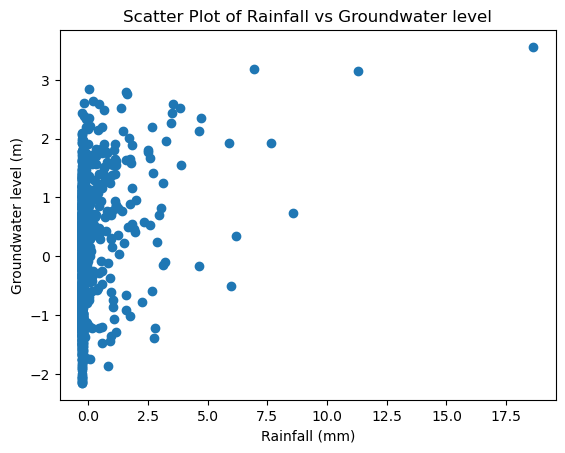

In [4]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(df['Rainfall'], df['Groundwater'])

# Adding title and labels
plt.title('Scatter Plot of Rainfall vs Groundwater level')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Groundwater level (m)')

# Display the plot
plt.show()

In [5]:
### Search for DBSCAN hyperparameters using silhouette score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

def find_optimal_dbscan_params(df, feature_columns, eps_range, min_samples_range):
    # Standardize the selected features
    X = df[feature_columns].values
    X_scaled = StandardScaler().fit_transform(X)

    # Initialize the best score tracking variables
    best_score = -1
    best_eps = None
    best_min_samples = None

    # Perform grid search over eps and min_samples
    for eps in eps_range:
        for min_samples in min_samples_range:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
            labels = db.labels_
            
            # Calculate the silhouette score only if valid clusters are found
            if len(set(labels)) > 1 and -1 not in labels:
                score = silhouette_score(X_scaled, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    # Output the best parameters and silhouette score
    print(f'Best eps: {best_eps}')
    print(f'Best min_samples: {best_min_samples}')
    print(f'Best silhouette score: {best_score}')

    return best_eps, best_min_samples

# Define parameters and dataframe
feature_columns = ['Rainfall', 'Groundwater']

#### Best eps_range so far: (0.25, 0.75, 0.01)
eps_range = np.arange(0.25, 0.75, 0.01) # Adjust start, stop, and step values in arrange() to adjust size/number of clusters
min_samples_range = range(1, 3)

# Run the function and retrieve the best parameters along with the modified dataframe
best_eps, best_min_samples = find_optimal_dbscan_params(df, feature_columns, eps_range, min_samples_range)

Best eps: 0.6600000000000004
Best min_samples: 1
Best silhouette score: 0.6769255341582503


In [6]:
# Rerun best model to get labels
from sklearn import metrics

# Select the columns to use for clustering
X = df[['Rainfall', 'Groundwater']].values

# Initialize and fit DBSCAN clustering
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the estimated number of clusters and noise points
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Add cluster labels back to the dataframe for further analysis
df['Cluster_Labels'] = labels


Estimated number of clusters: 12
Estimated number of noise points: 0


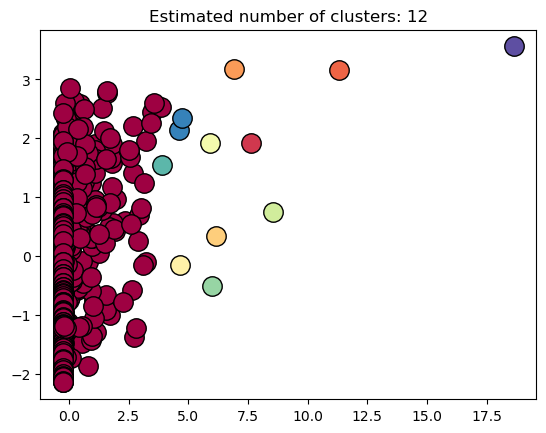

In [7]:
# Plot results
def plot_dbscan_results(X, labels, db, title='DBSCAN Clustering'):
    
    # Generate a mask for the core samples
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    # Determine unique labels
    unique_labels = set(labels)
    
    # Create a color map for the clusters
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:  # Noise
            col = [0, 0, 0, 1]
        
        class_member_mask = labels == k
        
        # Plot core samples
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        
        # Plot non-core samples
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    
    plt.title(title)
    plt.show()

plot_dbscan_results(X, labels, db, title=f"Estimated number of clusters: {len(set(labels))}")

In [8]:
# view the labels of each datapoint in the dataset
# '-1' means noise (doesn't belong to any cluster)
# '0', '1', and '2' are the labels of each cluster. 
for idx, (point, label) in enumerate(zip(X, labels)):
    print("Index number:", idx, "Data point:", point, "Label:", label)

Index number: 0 Data point: [-0.25541403  0.70991421] Label: 0
Index number: 1 Data point: [-0.10729224  0.7749192 ] Label: 0
Index number: 2 Data point: [-0.18705012  0.81577947] Label: 0
Index number: 3 Data point: [-0.23262606  0.77120463] Label: 0
Index number: 4 Data point: [7.64061664 1.92643604] Label: 1
Index number: 5 Data point: [0.02943557 2.34618251] Label: 0
Index number: 6 Data point: [-0.02753435  2.16602584] Label: 0
Index number: 7 Data point: [-0.20983809  1.98029731] Label: 0
Index number: 8 Data point: [-0.20983809  1.8057125 ] Label: 0
Index number: 9 Data point: [-0.22123207  1.61626941] Label: 0
Index number: 10 Data point: [-0.25541403  1.6051257 ] Label: 0
Index number: 11 Data point: [-0.25541403  1.41939717] Label: 0
Index number: 12 Data point: [-0.25541403  1.35439219] Label: 0
Index number: 13 Data point: [-0.25541403  1.35624948] Label: 0
Index number: 14 Data point: [-0.25541403  1.25409879] Label: 0
Index number: 15 Data point: [-0.25541403  1.19466566]

In [9]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Filter the dataframe to show flood dates based on a condition in 'Cluster_Labels'
flood_dates = df.loc[df['Cluster_Labels'] != 0, ['Date', 'Rainfall', 'Groundwater']]

# Order by 'Date'
flood_dates = flood_dates.sort_values(by='Date')

# Display the 'Date' of flood points
print("Flood dates:")
print(flood_dates)

Flood dates:
           Date   Rainfall  Groundwater
4    2021-01-05   7.640617     1.926436
310  2021-11-07  11.309479     3.154102
314  2021-11-11   6.934190     3.178246
363  2021-12-30   6.182187     0.338457
668  2022-10-31   4.643999    -0.159295
669  2022-11-01   5.897337     1.922721
707  2022-12-09   8.552135     0.741488
899  2023-06-19   5.977095    -0.510322
1054 2023-11-21   3.891996     1.549407
1062 2023-11-29   4.632605     2.134452
1066 2023-12-03   4.723757     2.346183
1067 2023-12-04  18.635811     3.558990
